## Prueba del Sistema Fuzzy Clásico (Mamdani)

En estas celdas cargamos el dataset, creamos el simulador, ejecutamos la inferencia sobre el test set y calculamos las métricas.

---

In [1]:
# 1) Ajustes de rutas e importaciones

# El notebook debe estás en <root>/notebooks/
import os, sys

# sube un nivel para que Python encuentre la carpeta src/

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Raiz del prooyecto añadida a sys.path:", project_root)


Raiz del prooyecto añadida a sys.path: c:\fuzzy_calidad_agua


In [2]:
# Importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import skfuzzy as fuzz
from skfuzzy import interp_membership 

from src.pertenencia.fuzzy_control_system import create_fuzzy_control_system, evaluate_dataset


In [24]:
# 2) Cargar y preparar datos
df = pd.read_csv('../data/processed/winsorized_water_quality.csv', sep=";")

# La columna de calidad: 0=Excellent,1=Good,2=Poor
y = df['Water Quality'].values.astype(int)

# Ver las primeros datos
df.head()


,Temp,Turbidity (cm),DO(mg/L),BOD (mg/L),CO2,PH,Alkalinity (mg L-1 ),Hardness (mg L-1 ),Calcium (mg L-1 ),Ammonia (mg L-1 ),Nitrite (mg L-1 ),Phosphorus (mg L-1 ),H2S (mg L-1 ),Water Quality
0,46.030363,10.1271,0.208200,7.473600,10.18110,4.7517,218.3649,300.125100,253.37435,0.07845,2.900975,0.0060,0.03385,2
1,46.030363,94.0156,10.335437,8.528388,13.03055,3.0852,271.4524,8.426800,253.37435,0.07845,2.182800,0.0049,0.02340,2
2,46.030363,90.6535,10.335437,8.528388,12.32000,9.6485,220.8127,11.726300,253.37435,0.07845,2.900975,0.0070,0.03385,2
3,4.023263,0.0663,10.335437,8.508000,12.95520,4.8200,266.5716,6.627700,8.18050,0.07845,2.900975,3.1745,0.02600,2
4,46.030363,2.1192,1.361700,8.528388,13.03055,10.2440,252.1080,302.469587,253.37435,0.07845,2.900975,3.8547,0.03385,2


In [25]:
# 1) Crear el sistema (usa el alias o el nombre canónico)
sim, meta = create_fuzzy_control_system(df)
# sim, meta = create_control_system(df)

# 2) Imprimir las claves de los antecedents
print("Claves en meta:", meta.keys())

# Ahora se extrae el diccionario de antecedentes
ante_dict = meta['antecedents']
print("Antecedentes registrados:", list(ante_dict.keys()))

Claves en meta: dict_keys(['antecedents', 'consequent', 'rules'])
Antecedentes registrados: ['Temp', 'Turbidity (cm)', 'DO(mg/L)', 'BOD (mg/L)', 'CO2', 'PH', 'Alkalinity (mg L-1 )', 'Hardness (mg L-1 )', 'Calcium (mg L-1 )', 'Ammonia (mg L-1 )', 'Nitrite (mg L-1 )', 'Phosphorus (mg L-1 )', 'H2S (mg L-1 )']


In [26]:
from src.pertenencia.fuzzy_control_system import infer

# 1) Extraer la primera muestra como diccionario
sample = df[list(meta['antecedents'].keys())].iloc[0].to_dict()

# 2) Ejecutar inferencia
crisp, memb = infer(sim, sample, meta['consequent'])

# 3) Mostrar resultados
print("Valor defuzzificado (crisp):", crisp)
print("Grados de pertenencia [poor, good, excellent]:", memb)


Valor defuzzificado (crisp): 0.3775758168683606
Grados de pertenencia [poor, good, excellent]: [0.62242418 0.         0.        ]


In [27]:
# Evaluar desempeño sobre el dataset completo
metrics = evaluate_dataset(
    df,                   # tu DataFrame con todos los datos
    sim,                  # el simulador fuzzy
    meta,                 # metadata (antecedents, consequent, rules)
    label_col='Water Quality',    # nombre de la columna de etiquetas (0,1,2)
    show_progress=True    # despliega una barra de progreso
)



Inferencia: 100%|██████████| 4300/4300 [00:49<00:00, 87.66it/s]


Métricas de desempeño:
  • Fuzzy Accuracy: 0.1633
  • FPI: 0.0978
  • RMSE: 0.9354


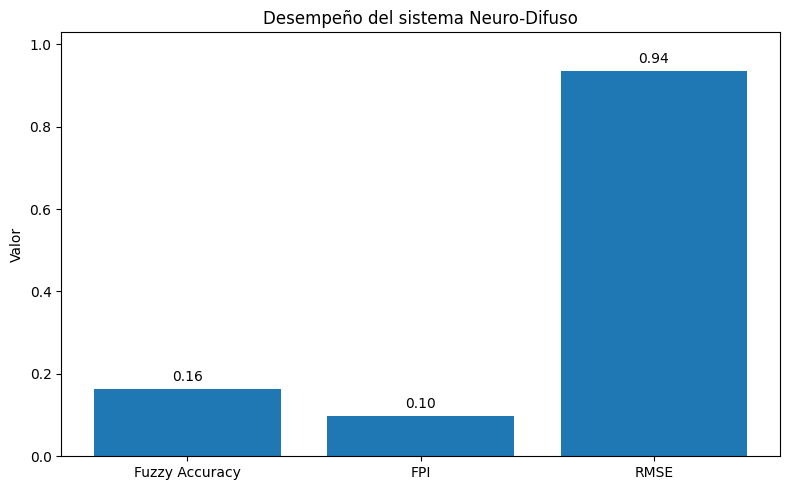

In [28]:
# 5) Métricas crudas: Confusión y reporte

import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Cargar métricas desde el CSV que generó evaluate_dataset ---
# (o usar directamente el dict 'metrics' si acabas de ejecutar evaluate_dataset)
try:
    metrics_df = pd.read_csv('../reports/metrics.csv', index_col=0)
    # metrics.csv debe tener una fila con los valores de accuracy, fuzzy_accuracy, FPI, rmse
    metrics = metrics_df.iloc[0].to_dict()
except FileNotFoundError:
    # si prefieres usar el diccionario en memoria:
    # metrics = metrics  # asume que 'metrics' ya existe
    raise

# --- 2) Imprimir en pantalla ---
print("Métricas de desempeño:")
for nombre, valor in metrics.items():
    print(f"  • {nombre}: {valor:.4f}")

# --- 3) Graficar con matplotlib ---
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values())
plt.title('Desempeño del sistema Neuro-Difuso')
plt.ylabel('Valor')
plt.ylim(0, max(metrics.values()) * 1.1)
for i, (nombre, valor) in enumerate(metrics.items()):
    plt.text(i, valor + (max(metrics.values())*0.02), f"{valor:.2f}", ha='center')
plt.tight_layout()
plt.show()


### Diagnóstico rápido
1. Predicción sesgada hacia “Good”

El sistema casi nunca predice “Excellent” (columna 2 es todo ceros).

La mayoría de las muestras de “Poor” y “Excellent” se clasifican como “Good”.

2. Bajo poder discriminativo

La Fuzzy Accuracy de ~0.16 y un FPI inferior a 0.10 indican que tu sistema difuso no está separando bien las tres categorías.

El RMSE cercano a 1 refleja que, en promedio, tus valores defuzzificados quedan a casi una unidad de la etiqueta real (0,1 ó 2).

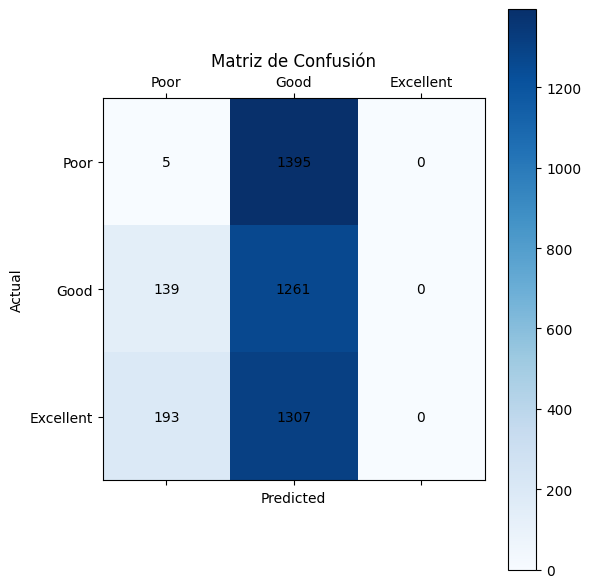

In [29]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Asegúrate de que infer sea importable; ajusta la ruta según tu estructura
# Si usas el alias de notebooks previos:
sys.path.append('src')  
from src.pertenencia.fuzzy_control_system import infer  # infer(sim, sample, cons) :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}

# 2) Generar predicciones sobre todo el dataset
preds = []
for _, row in df.iterrows():
    sample = row[list(meta['antecedents'].keys())].to_dict()
    # Aquí pasas el tercer argumento: el Consequent
    crisp, _ = infer(sim, sample, meta['consequent'])
    preds.append(int(round(crisp)))

df['pred'] = preds

# 3) Calcular la matriz de confusión
y_true = df['Water Quality']
y_pred = df['pred']
labels = [0, 1, 2]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 4) Visualizarla
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

ax.set_xticks(labels)
ax.set_xticklabels(['Poor','Good','Excellent'])
ax.set_yticks(labels)
ax.set_yticklabels(['Poor','Good','Excellent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

# Anotar valores en cada celda
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, v, ha='center', va='center')

plt.tight_layout()
plt.show()

### Posibles causas
1. Funciones de pertenencia (MFs) demasiado superpuestas

Si “Poor” y “Excellent” se solapan mucho con “Good”, casi todas las reglas disparan el término medio.

2. Conjunto de reglas desequilibrado

Tal vez tienes más reglas que tienden a “Good” o los pesos de tus reglas favorecen la salida media.

3. Defuzzificación centrada

Si usas centroid o bisector sin ajustar tus MFs, el resultado tiende al centro (1 = “Good”).

In [30]:
import warnings
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning

# 1) Filtrar solo las UndefinedMetricWarning
warnings.filterwarnings(
    "ignore",
    category=UndefinedMetricWarning,
    module="sklearn.metrics._classification"
)

# 2) Calcular el reporte con zero_division=0 para etiquetar a 0 las precisiones no definidas
report = classification_report(
    y_true,
    y_pred,
    target_names=['Poor','Good','Excellent'],
    zero_division=0
)
print(report)



              precision    recall  f1-score   support

        Poor       0.01      0.00      0.01      1400
        Good       0.32      0.90      0.47      1400
   Excellent       0.00      0.00      0.00      1500

    accuracy                           0.29      4300
   macro avg       0.11      0.30      0.16      4300
weighted avg       0.11      0.29      0.15      4300



In [31]:
from sklearn.preprocessing import label_binarize

# Etiquetas reales: vector N×1 de 0,1,2
y_true = df['Water Quality'].values

# One-hot: matriz N×3 donde cada fila es [1,0,0] si label=0, [0,1,0] si label=1, etc.
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
# Ahora y_true_bin.shape == (N, 3)


In [32]:
import numpy as np

# Inicializa una lista donde iremos apilando los vectores de memberships
memberships_list = []

for _, row in df.iterrows():
    sample = row[list(meta['antecedents'].keys())].to_dict()
    _, memb = infer(sim, sample, meta['consequent'])
    # 'memb' debería ser algo como [0.2, 0.7, 0.1]
    memberships_list.append(memb)

# Convierte a matriz N×3
membership_matrix = np.vstack(memberships_list)
# Ahora membership_matrix.shape == (N, 3)


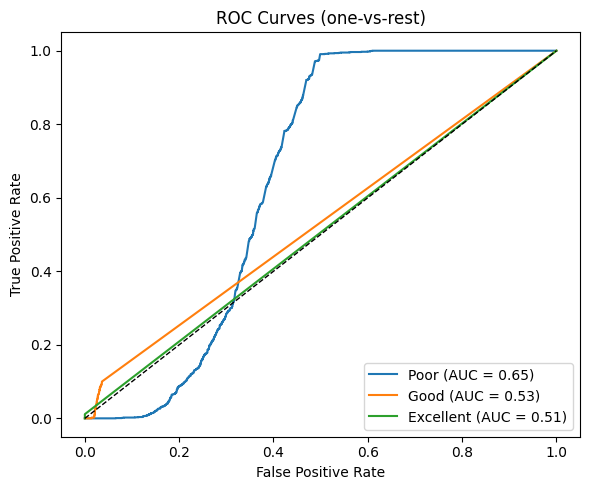

In [33]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['Poor','Good','Excellent']

for i in range(3):
    # Verdaderos vs. scores (membership) para la clase i
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], membership_matrix[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar
plt.figure(figsize=(6, 5))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # diagonal de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (one-vs-rest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


### Análisis de resultados:
1. Clase “Poor”

El sistema asigna memberships que, en promedio, ponen a las muestras realmente “Poor” con grados algo mayores que al resto.

Sin embargo, con un 0.65 AUC aún tenderá a confundir bastantes muestras “Poor” como “Good”.

2. Clases “Good” y “Excellent”

AUCs de ~0.5 implican que las funciones de pertenencia para estos términos están solapadas hasta el punto de que el membership no aporta señal discriminativa.

El modelo, al defuzzificar, termina colapsando casi todo al valor medio (1 = “Good”), lo cual confirma tu matriz de confusión.

### Siguientes acciones recomendadas
1. Revisar y reajustar MFs

Ensanchar o estrechar los triángulos de “Poor” y “Excellent” para que cubran de forma más exclusiva los extremos del rango.

Por ejemplo, si tu universo es [0,2], pasa de Poor = trimf([0,0,1]) a algo como trimf([0,0,0.8]) y de Excellent = trimf([1,2,2]) a trimf([1.2,2,2]).

2. Balance de reglas

Asegúrate de tener reglas suficientes que disparen salidas “Excellent”. Si tus umbrales de entrada no alcanzan los rangos altos, esas reglas quedan inactivas. Introduce reglas adicionales o lowering thresholds para “Excellent”.

3. Método de defuzzificación

Prueba con “mean of maxima” (MoM) o “smallest of maxima” (SoM) en lugar de “centroid”. Estos métodos pueden desplazarte hacia los bordes en lugar de promediar hacia el centro.

4. Ingeniería de atributos

Quizá necesites transformar o normalizar tus variables fisicoquímicas para que los rangos críticos estén mejor representados por las MFs.

5. Threshold tuning automatizado

Usa un pequeño grid search: varía los puntos de corte de tus MFs en pasos (p. ej. 0.1) y evalúa qué combinación maximiza el AUC de “Excellent” sin sacrificar demasiado “Poor”.

6. Curvas Precision–Recall

Si tus clases están desbalanceadas, a veces PR–AUC es más informativo para las minoritarias (como “Excellent” si hay pocas muestras).

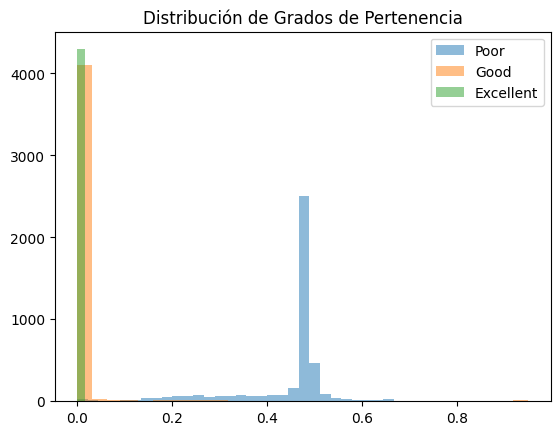

In [34]:
# membership_matrix: N×3 con μ_poor, μ_good, μ_excellent
plt.hist(membership_matrix[:,0], bins=30, alpha=0.5, label='Poor')
plt.hist(membership_matrix[:,1], bins=30, alpha=0.5, label='Good')
plt.hist(membership_matrix[:,2], bins=30, alpha=0.5, label='Excellent')
plt.legend(); plt.title("Distribución de Grados de Pertenencia")
plt.show()


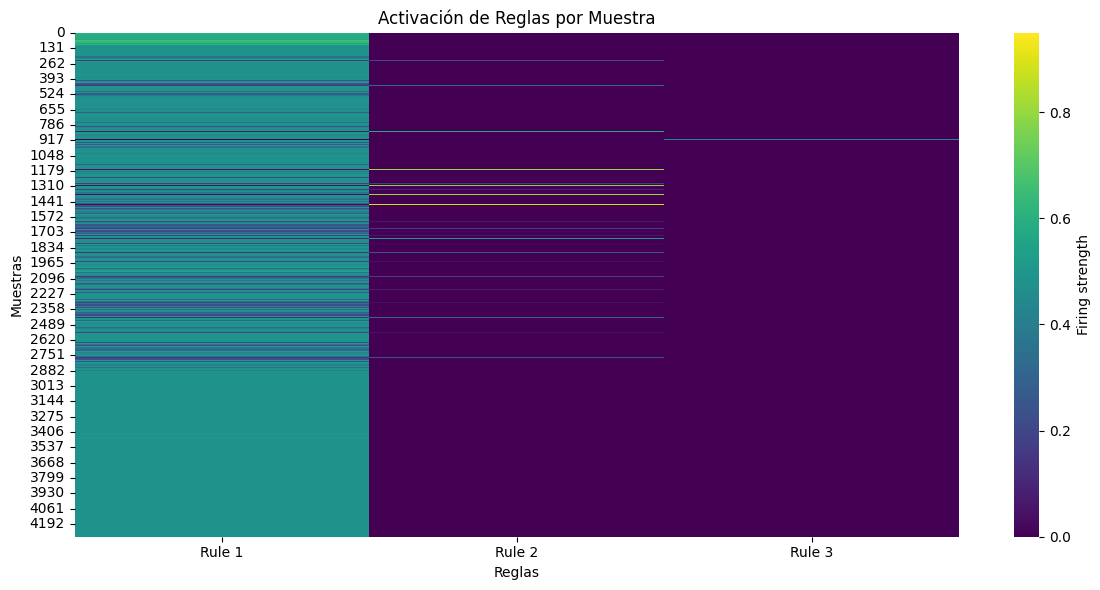

In [35]:
# Visualización de activaciones de reglas por muestra

# 1) Asegúrate de que infer (modificada) y tu simulador estén importables
sys.path.append('src')
from src.pertenencia.fuzzy_control_system import create_fuzzy_control_system, infer

# 2) Recrea el simulador y las reglas (meta)
sim, meta = create_fuzzy_control_system(df)

# 3) Recorre el dataset y recoge firing strengths
firing_list = []
for _, row in df.iterrows():
    sample = row[list(meta['antecedents'].keys())].to_dict()

    # Ejecuta la inferencia, modificada para que devuelva también firing strengths
    # Por ejemplo, cambia infer() en fuzzy_control_system.py a:
    #    def infer(sim, sample, cons):
    #        sim.input.update(sample)
    #        sim.compute()
    #        crisp = sim.output[cons.label]
    #        # Extrae activaciones de reglas (skfuzzy ControlSystemSimulation internals)
    #        fis = sim._fis  # tu objeto FIS interno
    #        activations = [rule.activation for rule in fis.control_system.rules]
    #        return float(crisp), np.array(activations)
    
    crisp, activations = infer(sim, sample, meta['consequent'])
    firing_list.append(activations)

# 4) Construye la matriz R
R = np.vstack(firing_list)
rule_names = [f"Rule {i+1}" for i in range(R.shape[1])]
R_df = pd.DataFrame(R, columns=rule_names)

# 5) Dibuja el heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(R_df, cmap="viridis", cbar_kws={'label':'Firing strength'})
plt.xlabel("Reglas")
plt.ylabel("Muestras")
plt.title("Activación de Reglas por Muestra")
plt.tight_layout()
plt.show()

El mapa de activaciones revela claramente por qué tu sistema siempre acaba en la categoría intermedia (“Good”):

- Rule 1 (“Good”) dispara prácticamente en todas las muestras con grado alto (verde-amarillo).

- Rule 2 solo se activa en contadas muestras (líneas muy tenues), y nunca de forma dominante.

- Rule 3 (“Excellent”) permanece siempre en cero: ¡nunca llega a disparar!

Interpretación:
- Tu base de reglas está desequilibrada, favoreciendo la salida “Good” por defecto.

- No tienes reglas configuradas —o con umbrales demasiado restrictivos— para “Poor” y “Excellent”, de modo que solo Rule 1 cubre la mayoría de los casos.